In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.linalg import inv

try:
    df = pd.read_csv('date.csv', header=None, delim_whitespace=True)
except:
    df = pd.read_csv('date.csv', header=None)

x = df[0].values
y = df[1].values

x_s = (x - x.mean()) / x.std()
y_s = (y - y.mean()) / y.std()

print("Datele au fost încarcate si standardizate.")

Datele au fost încarcate si standardizate.


/tmp/ipython-input-2873100979.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('date.csv', header=None, delim_whitespace=True)


In [9]:
import numpy as np
from numpy.linalg import inv

def get_poly(x, order):
    return np.vander(x, order + 1, increasing=True)

def bayes_fit(x, y, order, sd_prior):
    beta = 1.0

    Phi = get_poly(x, order)

    if np.isscalar(sd_prior):
        S0_inv = (1/sd_prior**2) * np.eye(order + 1)
    else:
        sd = np.array(sd_prior)
        if len(sd) != order + 1:
            sd = np.pad(sd, (0, order + 1 - len(sd)), constant_values=sd[-1])
        S0_inv = np.diag(1/sd**2)

    SN_inv = S0_inv + beta * (Phi.T @ Phi)
    SN = inv(SN_inv)

    mN = SN @ (beta * Phi.T @ y)
    return mN, SN

def predict(x, mN, SN, order):
    Phi = get_poly(x, order)
    y_pred = Phi @ mN
    y_var = 1.0 + np.sum((Phi @ SN) * Phi, axis=1)
    return y_pred, np.sqrt(y_var)

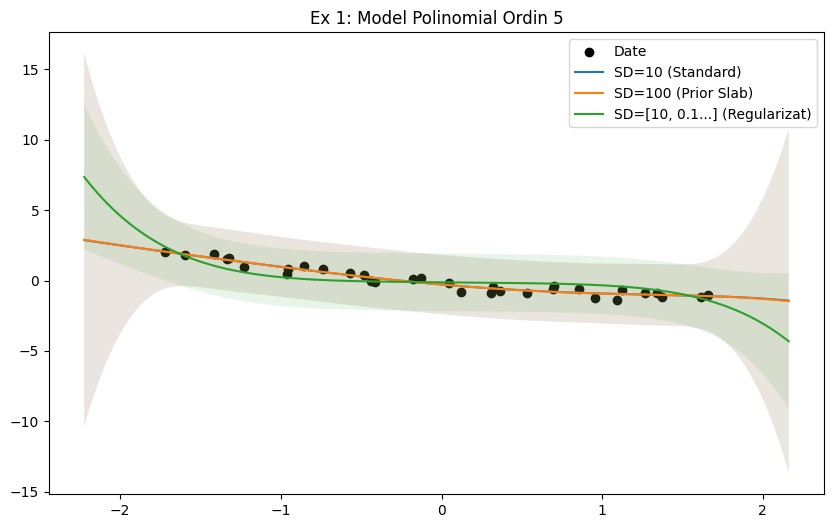

In [11]:
# --- EXERCIȚIUL 1 ---
x_plot = np.linspace(x_s.min()-0.5, x_s.max()+0.5, 200)

scenarios = [
    (10, 'SD=10 (Standard)'),
    (100, 'SD=100 (Prior Slab)'),
    ([10, 0.1, 0.1, 0.1, 0.1, 0.1], 'SD=[10, 0.1...] (Regularizat)')
]

plt.figure(figsize=(10, 6))
plt.scatter(x_s, y_s, c='black', label='Date')

for sd, label in scenarios:
    w, cov = bayes_fit(x_s, y_s, 5, sd)
    mu, sigma = predict(x_plot, w, cov, 5)
    plt.plot(x_plot, mu, label=label)
    plt.fill_between(x_plot, mu - 2*sigma, mu + 2*sigma, alpha=0.1)

plt.title("Ex 1: Model Polinomial Ordin 5")
plt.legend()
plt.show()

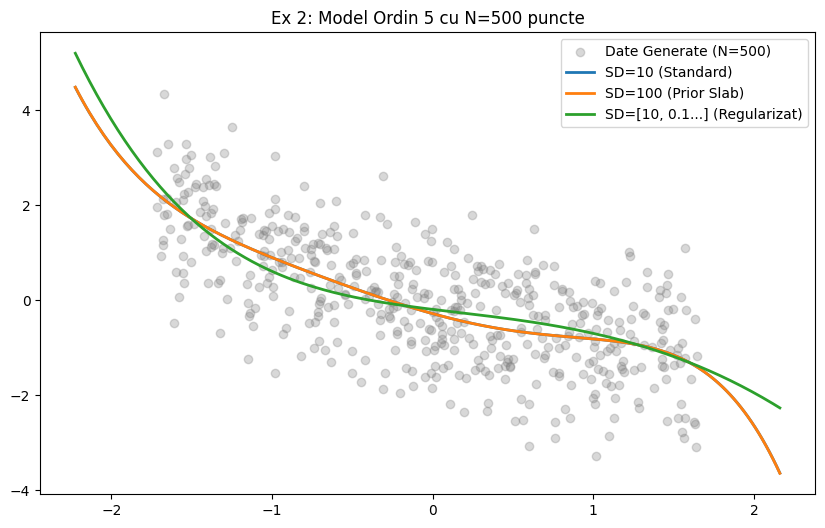

In [12]:
# --- EXERCIȚIUL 2 ---
w_true, _ = bayes_fit(x_s, y_s, 5, 10)
x_new = np.random.uniform(x_s.min(), x_s.max(), 500)
y_new = get_poly(x_new, 5) @ w_true + np.random.normal(0, 1, 500)

plt.figure(figsize=(10, 6))
plt.scatter(x_new, y_new, c='gray', alpha=0.3, label='Date Generate (N=500)')

for sd, label in scenarios:
    w, cov = bayes_fit(x_new, y_new, 5, sd)
    mu, _ = predict(x_plot, w, cov, 5)
    plt.plot(x_plot, mu, label=label, linewidth=2)

plt.title("Ex 2: Model Ordin 5 cu N=500 puncte")
plt.legend()
plt.show()

In [13]:
# --- EXERCIȚIUL 3 ---
print(f"{'Ordin':<10} {'WAIC':<10} {'LOO':<10}")
print("-" * 30)

for order in [1, 2, 3]:
    w, cov = bayes_fit(x_s, y_s, order, 10)

    w_samples = np.random.multivariate_normal(w, cov, 2000)
    Phi = get_poly(x_s, order)
    y_est = w_samples @ Phi.T
    log_lik = norm.logpdf(y_s, loc=y_est, scale=1.0)

    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0)))
    p_waic = np.sum(np.var(log_lik, axis=0))
    waic = -2 * (lppd - p_waic)

    loo_lppd = 0
    for i in range(len(x_s)):
        x_tr = np.delete(x_s, i)
        y_tr = np.delete(y_s, i)

        w_l, cov_l = bayes_fit(x_tr, y_tr, order, 10)
        mu_l, s_l = predict(np.array([x_s[i]]), w_l, cov_l, order)

        loo_lppd += norm.logpdf(y_s[i], loc=mu_l[0], scale=s_l[0])

    loo = -2 * loo_lppd
    print(f"{order:<10} {waic:<10.2f} {loo:<10.2f}")

Ordin      WAIC       LOO       
------------------------------
1          66.90      66.85     
2          66.08      66.06     
3          67.41      67.35     


In [2]:
from google.colab import files

uploaded = files.upload()

Saving date.csv to date.csv
